In [23]:
import numpy as np 
from scipy import stats
import pymc3 as pm
import arviz as az
import theano
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
az.style.use("arviz-darkgrid")
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Chapter 5 - Model comparison

### Load dummy data

Text(0, 0.5, 'y')

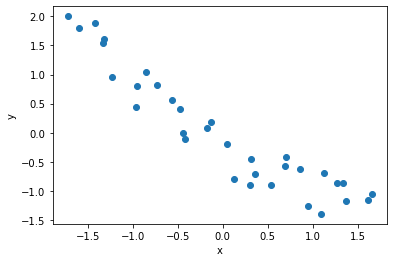

In [2]:
dummy_data = np.loadtxt('../data/dummy.csv')
x_1 = dummy_data[:, 0]
y_1 = dummy_data[:, 1]
order = 2
x_1p = np.vstack([x_1**i for i in range(1, order+1)])
x_1s = (x_1p - x_1p.mean(axis=1, keepdims=True)) / x_1p.std(axis=1, keepdims=True)
y_1s = (y_1 - y_1.mean()) / y_1.std()
plt.scatter(x_1s[0], y_1s)
plt.xlabel('x')
plt.ylabel('y')

### Fit linear 

In [3]:

with pm.Model() as model_l:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + β * x_1s[0]
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)

    trace_l = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 19 seconds.


### parabolic model;

In [4]:
with pm.Model() as model_p:
    α = pm.Normal('α', mu=0, sd=1)
    β = pm.Normal('β', mu=0, sd=10, shape=order)
    ϵ = pm.HalfNormal('ϵ', 5)
    μ = α + pm.math.dot(β, x_1s)
    y_pred = pm.Normal('y_pred', mu=μ, sd=ϵ, observed=y_1s)
    
    trace_p = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ϵ, β, α]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 21 seconds.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6716568625870327, but should be close to 0.8. Try to increase the number of tuning steps.


### plot mean fit for both models

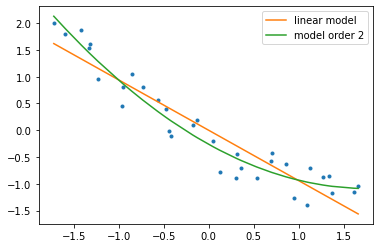

In [5]:
x_new = np.linspace(x_1s[0].min(), x_1s[0].max(), 100)
α_l_post = trace_l['α'].mean()
β_l_post = trace_l['β'].mean(axis=0)
y_l_post = α_l_post + β_l_post * x_new
plt.plot(x_new, y_l_post, 'C1', label='linear model')
α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
idx = np.argsort(x_1s[0])
y_p_post = α_p_post + np.dot(β_p_post, x_1s)
plt.plot(x_1s[0][idx], y_p_post[idx], 'C2', label=f'model order {order}')
α_p_post = trace_p['α'].mean()
β_p_post = trace_p['β'].mean(axis=0)
x_new_p = np.vstack([x_new**i for i in range(1, order+1)])
y_p_post = α_p_post + np.dot(β_p_post, x_new_p)
plt.scatter(x_1s[0], y_1s, c='C0', marker='.')
plt.legend()

Get posterior predictive samples from both 

In [6]:
y_l = pm.sample_posterior_predictive(trace_l, 2000,model=model_l)['y_pred']
y_p = pm.sample_posterior_predictive(trace_p, 2000,model=model_p)['y_pred']

C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\pymc3\sampling.py:1688: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(


### Plot again!

([], [])

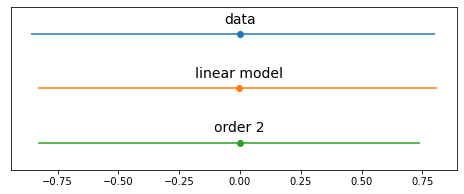

In [7]:
plt.figure(figsize=(8, 3))
data = [y_1s, y_l, y_p]
labels = ['data', 'linear model', 'order 2']
for i, d in enumerate(data):
    mean = d.mean()
    err = np.percentile(d, [25, 75])
    plt.errorbar(mean, -i, xerr=[[-err[0]], [err[1]]], fmt='o')
    plt.text(mean, -i+0.2, labels[i], ha='center', fontsize=14)
plt.ylim([-i-0.5, 0.5])
plt.yticks([])

plot the dispersion of both the mean and the interquartile range, as opposed to their mean
values

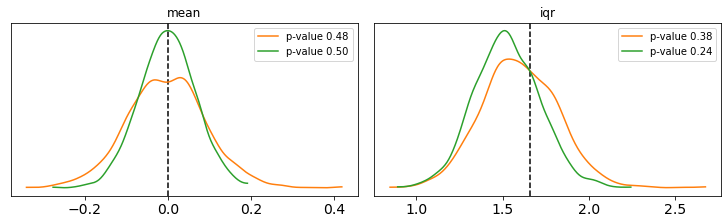

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3), constrained_layout=True)

def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))

for idx, func in enumerate([np.mean, iqr]):
    T_obs = func(y_1s)
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')

    for d_sim, c in zip([y_l, y_p], ['C1', 'C2']):
        T_sim = func(d_sim, 1)
        p_value = np.mean(T_sim >= T_obs)
        az.plot_kde(T_sim, plot_kwargs={'color': c}, label=f'p-value {p_value:.2f}', ax=ax[idx])
    ax[idx].set_title(func.__name__)
    ax[idx].set_yticks([])
    ax[idx].legend()



## Doing actual model comparison

Text(0, 0.5, 'y')

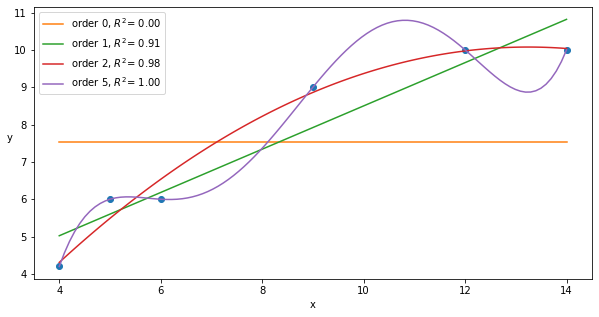

In [9]:
#Simple data and different polynomials
x = np.array([4., 5., 6., 9., 12, 14.])
y = np.array([4.2, 6., 6., 9., 10, 10.])
plt.figure(figsize=(10, 5))
order = [0, 1, 2, 5]
plt.plot(x, y, 'o')
for i in order:
    x_n = np.linspace(x.min(), x.max(), 100)
    coeffs = np.polyfit(x, y, deg=i)
    ffit = np.polyval(coeffs, x_n)
    p = np.poly1d(coeffs)
    yhat = p(x)
    ybar = np.mean(y)
    ssreg = np.sum((yhat-ybar)**2)
    sstot = np.sum((y - ybar)**2)
    r2 = ssreg / sstot
    plt.plot(x_n, ffit, label=f'order {i}, $R^2$= {r2:.2f}')

    plt.legend(loc=2)
    
plt.xlabel('x')
plt.ylabel('y', rotation=0)


In [11]:
waic_l = az.waic(trace_l)
waic_l

Computed from 8000 by 33 log-likelihood matrix

          Estimate       SE
elpd_waic   -14.40     2.67
p_waic        2.47        -

In [12]:
cmp_df = az.compare({'model_l':trace_l, 'model_p':trace_p}, method='BB-pseudo-BMA')

cmp_df

C:\Users\emilr\Anaconda3\envs\CM\lib\site-packages\arviz\stats\stats.py:146: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
model_p,0,-4.630846,2.716289,0.000000,0.99836,2.687052,0.000000,False,log
model_l,1,-14.429240,2.500041,9.798394,0.00164,2.347364,2.698535,False,log


<AxesSubplot:xlabel='Log'>

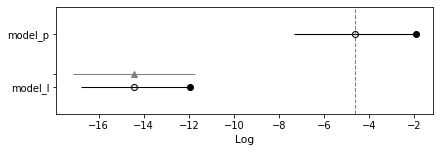

In [13]:
az.plot_compare(cmp_df)

### Bayes factors

In [16]:
#Data town
coins = 30
heads = 9
y_d = np.repeat([0, 1], [coins-heads, heads])

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [model_index]
>NUTS: [θ]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 32 seconds.


array([[<AxesSubplot:title={'center':'model_index'}>,
        <AxesSubplot:title={'center':'model_index'}>],
       [<AxesSubplot:title={'center':'θ'}>,
        <AxesSubplot:title={'center':'θ'}>]], dtype=object)

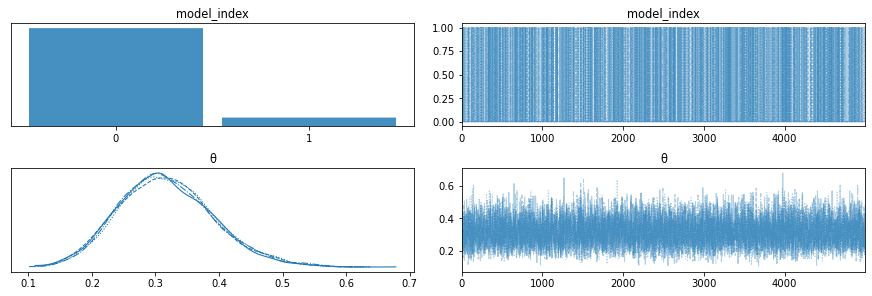

In [17]:
with pm.Model() as model_BF:
    p = np.array([0.5, 0.5])
    model_index = pm.Categorical('model_index', p=p)

    m_0 = (4, 8)
    m_1 = (8, 4)
    m = pm.math.switch(pm.math.eq(model_index, 0), m_0, m_1)

    # a priori
    θ = pm.Beta('θ', m[0], m[1])

    # likelihood
    y = pm.Bernoulli('y', θ, observed=y_d)

    trace_BF = pm.sample(5000)
    
az.plot_trace(trace_BF)

In [18]:
pM1 = trace_BF['model_index'].mean()
pM0 = 1 - pM1
BF = (pM0 / pM1) * (p[1] / p[0])

In [19]:
BF

11.492192379762649

Using Sequential monte carlo:

In [24]:
with pm.Model() as model_BF_0:
    θ = pm.Beta('θ', 4, 8)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_0 = pm.sample_smc(2500)

with pm.Model() as model_BF_1:
    θ = pm.Beta('θ', 8, 4)
    y = pm.Bernoulli('y', θ, observed=y_d)
    trace_BF_1 = pm.sample_smc(2500)


Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Stage:   0 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.202
Stage:   1 Beta: 0.676
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.206
Stage:   1 Beta: 0.667
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.203
Stage:   1 Beta: 0.669
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.201
Stage:   1 Beta: 0.659
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.204
Stage:   1 Beta: 0.666
Stage:   2 Beta: 1.000
Stage:   0 Beta: 0.208
Stage:   1 Beta: 0.699
Stage:   2 Beta: 1.000


AttributeError: 'Model' object has no attribute 'marginal_likelihood'

# Exercises: